In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


from sklearn import preprocessing

In [2]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3]:
base_csv = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv("1-P-3-ISEAR.csv",header=None)


df.columns = ['sn','Target','Sentence']
df.drop('sn',inplace=True,axis =1)


df.head()

,Target,Sentence
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [4]:
emotion = {        
    'joy':1,
    'sadness':2,
    'anger':3,
    'fear': 4,
    'shame':5,
    'disgust':6,
    'guilt':0
    }

def get_key(val):
    for key, value in emotion.items():
         if val == value:
             return key

In [5]:
X,y = df['Sentence'].values,df['Target'].values


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=10)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (5956,)
shape of test data is (1490,)


In [6]:
y_train

array(['sadness', 'guilt', 'fear', ..., 'disgust', 'guilt', 'fear'],
      dtype=object)

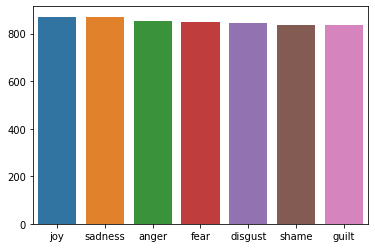

In [7]:
dd = pd.Series(y_train).value_counts()

# dd
sns.barplot(x=np.array(['joy','sadness','anger','fear','disgust','shame','guilt']),y=dd.values)
plt.show()

In [8]:
# dd

In [9]:
def preprocess_string(s):    
    s = re.sub(r"[^\w\s]", '', s) # Remove all non-word characters 
    s = re.sub(r"\s+", '', s) # Replace all runs of whitespaces with no space
    s = re.sub(r"\d", '', s) # replace digits with no space
    return s

In [10]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000] # sorting on the basis of most common words
    
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])

   
    encoded_train = [emotion[label] for label in y_train]
    encoded_test = [emotion[label] for label in y_val]


    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [12]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [13]:
y_test

array([4, 3, 1, ..., 2, 1, 1])

In [14]:
y_test

array([4, 3, 1, ..., 2, 1, 1])

In [15]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


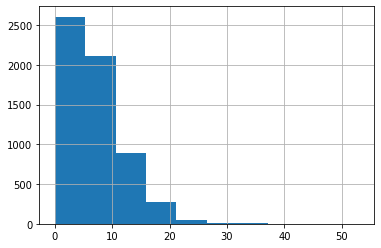

count    5956.000000
mean        7.239087
std         4.772394
min         0.000000
25%         4.000000
50%         6.000000
75%        10.000000
max        53.000000
dtype: float64

In [16]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [17]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [18]:

x_train_pad = padding_(x_train, 100)
x_test_pad = padding_(x_test,100)



In [19]:
y_train.shape

(5956,)

In [20]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 32

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True)
valid_loader = DataLoader(valid_data, shuffle=True)

In [21]:
train_data[0]

(tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,  40,  51, 682, 368, 310, 139,
         948, 191], dtype=torch.int32),
 tensor(2, dtype=torch.int32))

In [23]:
pd.Series(y_train).value_counts()

1    871
2    869
3    851
6    849
5    844
4    836
0    836
dtype: int64

In [24]:
class LSTMModel(nn.Module):
    
    def __init__(self, vocab_size,output_size, embedding_dim, hidden_size, num_layers, dropout = 0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size = embedding_dim, 
                            hidden_size = hidden_size, 
                            num_layers = num_layers,
                            dropout = dropout,
                            batch_first = True,
                            bidirectional = True)
        self.linear = nn.Linear(hidden_size*200, output_size)
        
    def forward(self, inputs):
        emb = self.embedding(inputs)
        
        h0 = torch.zeros(n_layers*2, inputs.size(0), hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(n_layers*2, inputs.size(0), hidden_dim).requires_grad_().to(device)
        
        lstm_out, h = self.lstm(emb, (h0, c0))
        
        output = self.linear(lstm_out.reshape(lstm_out.size()[0], -1))
        
        return output

In [25]:
vocab_size = len(vocab)+1
embedding_dim = 100
hidden_dim = 32
n_layers = 2
output_size = 7

model = LSTMModel(vocab_size,output_size, embedding_dim, hidden_dim, n_layers).to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
num_epochs  = 5

loss_list = []
iteration_list_train = []
count_train = 0

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets.type(torch.LongTensor))
 

            loss_list.append(loss.data) 
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            count_train += 1
            iteration_list_train.append(count_train) 
            

            if (i+1) % 2500 == 0:       
                print('Epoch '+ str(epoch+1) +'/'+str(num_epochs) +', Loss:' + str(loss.item()))

Epoch 1/5, Loss:1.861142873764038
Epoch 1/5, Loss:1.6610369682312012
Epoch 2/5, Loss:2.8628344535827637
Epoch 2/5, Loss:1.2050210237503052
Epoch 3/5, Loss:0.31064480543136597
Epoch 3/5, Loss:1.216158390045166
Epoch 4/5, Loss:0.5631343722343445
Epoch 4/5, Loss:0.13528946042060852
Epoch 5/5, Loss:0.015366964973509312
Epoch 5/5, Loss:2.9444261599564925e-05


In [28]:
accuracy_list = []
iteration_list_test = []
count_test = 0

y_pred = []
y_true = []

correct = 0
total = 0
for inputs, targets in valid_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)

    total += targets.size(0)                    
    correct += (predicted == targets).sum()    

    count_test += 1
    iteration_list_test.append(count_test)  

    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    
    y_pred.extend(predicted.cpu())
    y_true.extend(targets.cpu())
    
print('Accuracy of the network on the test: %d %%' %accuracy)

Accuracy of the network on the test: 48 %


In [29]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,100))
        inputs = pad.to(device)
        batch_size = 1
                
        predict = model(inputs.to(device))
        _, predicted = torch.max(predict.data, 1)

        return(predicted)

In [30]:
predicted = predict_text('Have a wonderful dream.')

print("Emotion of the given line is: "+get_key(predicted))

Emotion of the given line is: joy
